In [17]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [18]:
start_day_to_analyze = '2020-02-28'
end_day_to_analyze = '2020-02-29'

In [19]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [20]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [21]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [22]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [23]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [24]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [25]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [26]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,74,algo.py,PAPER,v0.1-133-ge39e721,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-02-28 14:45:28.342428,2020-02-28 21:10:00.257144,market close


,symbol,count,revenue,%
2,CBLI,5,-151.53,-15.19
11,DYAI,3,-126.78,-11.75
13,DNLI,2,-113.24,-3.93
4,PRTK,4,-102.01,-5.95
22,MIK,2,-100.21,-3.77
37,KRMD,1,-77.04,-1.27
9,MNRL,3,-73.95,-2.55
18,XAIR,2,-62.64,-4.62
34,GLYC,1,-60.34,-3.68
19,NTLA,2,-56.83,-1.21


TOTAL REVENUE: -617.39 $


In [27]:
minute_history = {}

for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [28]:
high_15m = {}

lbound = datetime.strptime(start_day_to_analyze, '%Y-%m-%d') + timedelta(minutes=9*60+30)
ubound = lbound + timedelta(minutes=15)

for symbol, count in symbols.items():
    try:
        high_15m[symbol] = minute_history[symbol][pd.Timestamp(str(lbound)):pd.Timestamp(str(ubound))]["high"].max()
    except:
        print(symbol)

MNRL
WTID
ICAD
DPK


In [30]:
bbands = {}

for symbol, count in symbols.items():
    upperband, middleband, lowerband = BBANDS(minute_history[symbol]["close"].dropna().between_time("9:30", "16:00"),
                                              timeperiod=20)
    bbands[symbol] = upperband
    
                                              

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
89,DSLV,74,False,0.209314,False,0.07,0.05
61,XAIR,74,False,0.408401,False,0.06,0.04
32,CLNC,74,False,-0.152672,False,0.02,0.01
33,CODX,74,False,3.750543,False,0.07,-0.01
35,CODX,74,False,1.005820,False,0.07,-0.01
73,PBI,74,False,0.718391,False,0.01,0.00
38,TPC,74,False,0.961538,False,NaN,NaN
39,MNRL,74,False,-0.323415,False,NaN,NaN
40,MNRL,74,False,2.324037,False,NaN,NaN
71,BCLI,74,False,-1.063830,False,NaN,NaN


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
89,DSLV,74,False,0.209314,False,0.07,0.05
60,XAIR,74,False,3.925121,False,0.06,0.04
73,PBI,74,False,0.718391,False,0.01,0.00
29,OPGN,74,False,2.518892,False,0.11,0.07
30,CLNC,74,False,3.235991,False,0.02,0.01
33,CODX,74,False,3.750543,False,0.07,-0.01
70,FINZ,74,False,2.161094,False,NaN,NaN
35,CODX,74,False,1.005820,False,0.07,-0.01
69,MIK,74,False,0.710900,False,0.01,0.00
38,TPC,74,False,0.961538,False,NaN,NaN


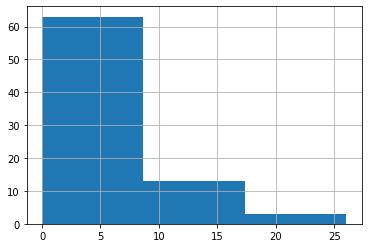

In [14]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(f'1 {symbol}')
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                print(f'2 {symbol}')
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                print(f'3 {symbol}')
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                print(f'4 {symbol}')
                continue
                
            if math.isnan(max_val):
                print(f'5 {symbol}')
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


NVAX analysis for run 74
buy-price 15.12 sell-price 15.66
buy-price 15.42 sell-price 15.18
buy-price 15.71 sell-price 16.25
buy-price 16.74 sell-price 16.21


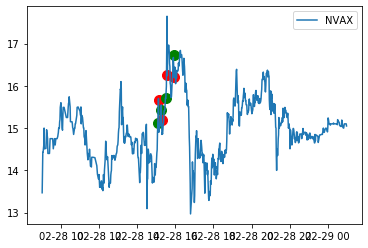

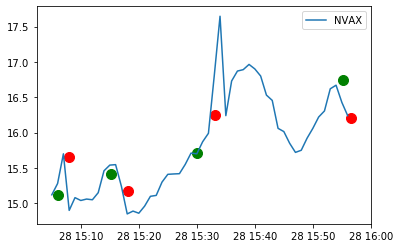

Delta = 0.3100000000000023


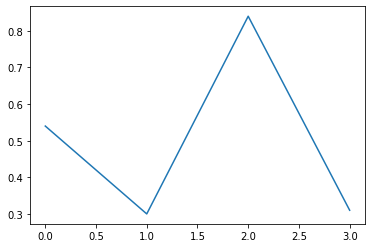

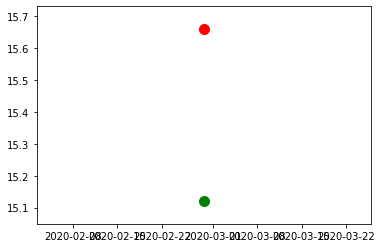

buy time:2020-02-28T15:06:02.607502477Z sell time:2020-02-28T15:07:55.677376166Z
{'rsi': 71.5161222334321, 'macd1': [0.20804099078425153, 0.22273902938612444, 0.23809801655982987, 0.2801245960656136, 0.32740895783150314], 'macd2': [0.39628208467673076, 0.3975436478258505, 0.39934799897132045, 0.40692673547265734, 0.41676718559168435], 'sell_macd': [0.10435083557924685, 0.11493865593090291, 0.1258520398941272, 0.15402023467204096, 0.18539778599675394], 'macd_signal': [0.24508406699829757, 0.24061505947586295, 0.24011165089265635, 0.2481142399272478, 0.26397318350809884], 'sell_macd_signal': [0.12497065328666239, 0.12296425381551049, 0.12354181103123382, 0.12963749575939526, 0.140789553806867]}
{'rsi': 77.28790355542759, 'macd': [0.1258520398941272, 0.15402023467204096, 0.18539778599675394, 0.21573616643163618, 0.253213655518147], 'scalp': 1, 'bail_out': 0, 'movement': 0.03174603174603178, 'too_close': 0, 'macd_signal': [0.12354181103123382, 0.12963749575939526, 0.140789553806867, 0.1557

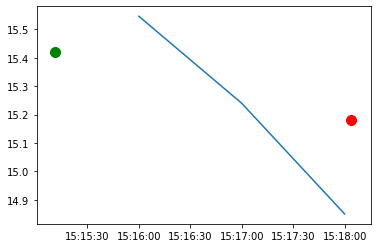

buy time:2020-02-28T15:15:11.213346551Z sell time:2020-02-28T15:18:03.942596063Z
{'rsi': 65.58126416956846, 'macd1': [0.39385020830352246, 0.3792748475727805, 0.3715103928968677, 0.38592273874455074, 0.3920187619728548], 'macd2': [0.4514536046555584, 0.45168197545740085, 0.4527690419560866, 0.4580030538895734, 0.46192606438273387], 'sell_macd': [0.22836937015163983, 0.21872533974050512, 0.21356472721571684, 0.22287379892087245, 0.22671367558825573], 'macd_signal': [0.3698062575614055, 0.3716999755636805, 0.37166205903031796, 0.3745141949731645, 0.3780151083731026], 'sell_macd_signal': [0.21216444700462467, 0.21347662555180075, 0.21349424588458396, 0.21537015649184166, 0.21763886031112448]}
{'rsi': 56.516015855583746, 'macd': [0.22287379892087245, 0.23139419506877346, 0.2353712025207919, 0.21948093297014637, 0.2000926588661347], 'scalp': 0, 'bail_out': 0, 'movement': -0.018770226537216776, 'too_close': 1, 'macd_signal': [0.21537015649184166, 0.21857496420722802, 0.2219342118699408, 0.22

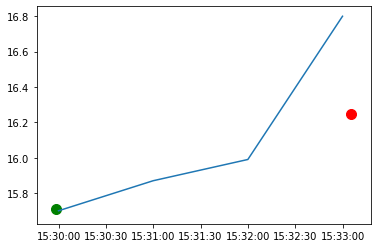

buy time:2020-02-28T15:29:58.691243112Z sell time:2020-02-28T15:33:05.619616633Z
{'rsi': 67.72424145423871, 'macd1': [0.21182333236601636, 0.217732766986364, 0.2201924919226883, 0.23006045314718548, 0.24873922102225166], 'macd2': [0.4210218886211745, 0.4195451786085904, 0.4175779293269475, 0.4171953014523506, 0.418896537779716], 'sell_macd': [0.11215477779121841, 0.11658150767440922, 0.11871945943177309, 0.12564877950982556, 0.13825281100558406], 'macd_signal': [0.24813056669402805, 0.24205100675249525, 0.23767930378653385, 0.23615553365866418, 0.23867227113138167], 'sell_macd_signal': [0.13416291145845202, 0.13064663070164345, 0.12826119644766937, 0.1277387130601006, 0.1298415326491973]}
{'rsi': 77.07192204057527, 'macd': [0.13772813568090747, 0.14483765820797423, 0.1573225113692196, 0.17124677991864345, 0.19743131671145875], 'scalp': 1, 'bail_out': 0, 'movement': 0.038676844783714935, 'too_close': 0, 'macd_signal': [0.12973659758426198, 0.13275680970900444, 0.13766995004104748, 0.144

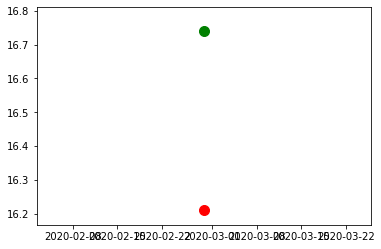

buy time:2020-02-28T15:55:15.29648462Z sell time:2020-02-28T15:56:37.505086132Z
{'rsi': 62.011804463072764, 'macd1': [0.07926726545822405, 0.08783634806255947, 0.1185176937148178, 0.145273532117983, 0.1701645903299429], 'macd2': [0.40962730062422814, 0.4042599125842443, 0.40368118426343713, 0.4033187777847367, 0.403459852387444], 'sell_macd': [0.0254956698014972, 0.03226182671679467, 0.05337491227784952, 0.07178283723090573, 0.08883079385366344], 'macd_signal': [0.18794432417418647, 0.16792272895186106, 0.1580417219044524, 0.15548808394715852, 0.1584233852237154], 'sell_macd_signal': [0.0940394213022653, 0.08168390238517118, 0.07602210436370685, 0.07517425093714662, 0.07790555952044999]}
{'rsi': 52.097023615468316, 'macd': [0.03226182671679467, 0.05337491227784952, 0.07178283723090573, 0.07257105359392568, 0.06408692279116224], 'scalp': 0, 'bail_out': 0, 'movement': -0.028076463560334462, 'too_close': 1, 'macd_signal': [0.08168390238517118, 0.07602210436370685, 0.07517425093714662, 0.0

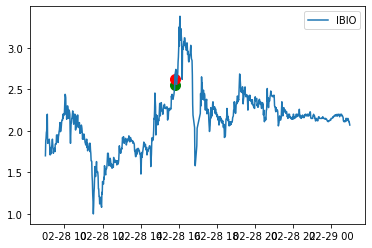

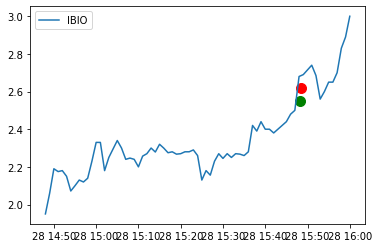

Delta = 0.07000000000000028


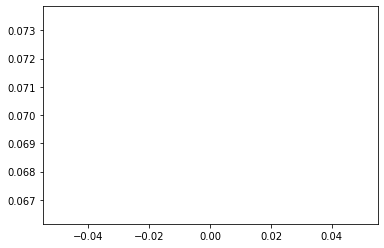

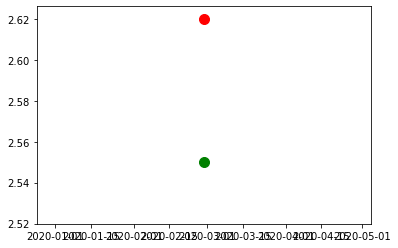

buy time:2020-02-28T15:48:07.958474171Z sell time:2020-02-28T15:48:25.166234482Z
{'rsi': 71.97835221062648, 'macd1': [0.0502290904491276, 0.052403147996558985, 0.05669218854800473, 0.06100990193106881, 0.06768606025761681], 'macd2': [0.11225289377785552, 0.1114854269732799, 0.11123917234504255, 0.11115617011035495, 0.11170170676670921], 'sell_macd': [0.029218206278359915, 0.030631119933963724, 0.03340701213399333, 0.03618034356084765, 0.04046890904202183], 'macd_signal': [0.04179984119667838, 0.0439205025566545, 0.04647483975492454, 0.0493818521901534, 0.05304269380364608], 'sell_macd_signal': [0.023313701518794933, 0.024777185201828693, 0.02650315058826162, 0.028438589182778827, 0.03084465315462743]}
{'rsi': 76.7828892066495, 'macd': [0.029218206278359915, 0.030631119933963724, 0.03340701213399333, 0.03618034356084765, 0.04541436358747619], 'scalp': 1, 'bail_out': 0, 'movement': 0.037333333333333406, 'too_close': 0, 'macd_signal': [0.023313701518794933, 0.024777185201828693, 0.0265031

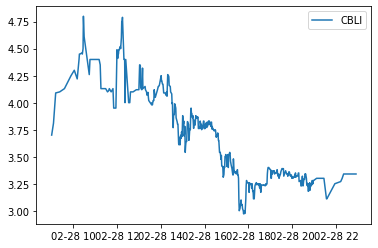

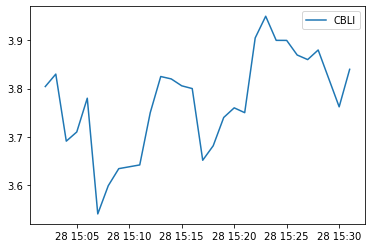

Delta = 0


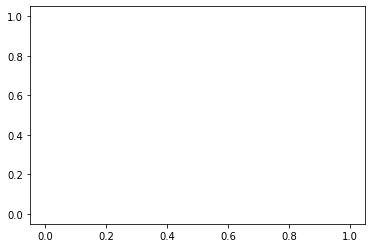

BIMI analysis for run 74


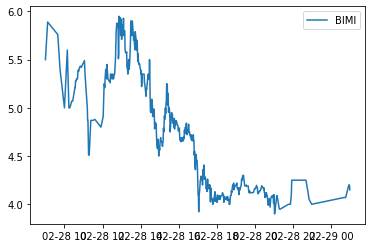

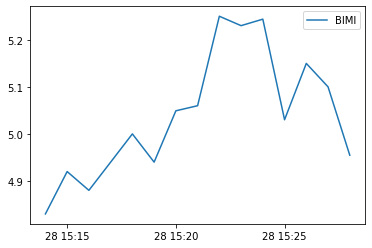

Delta = 0


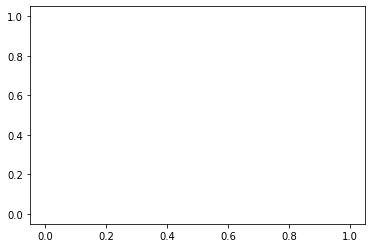

PRTK analysis for run 74
buy-price 4.6 sell-price 4.48
buy-price 4.59 sell-price 4.6


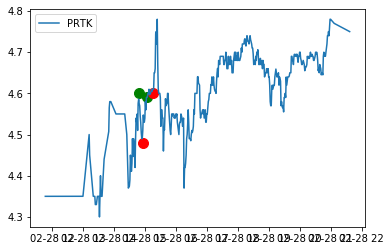

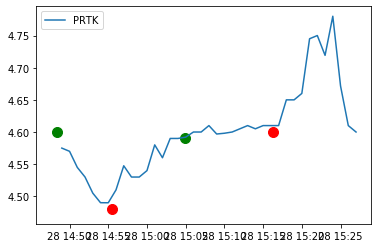

Delta = -0.10999999999999943


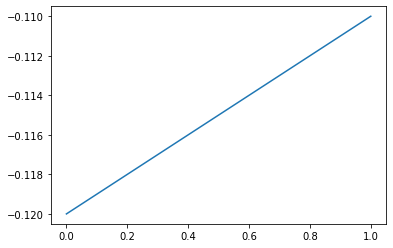

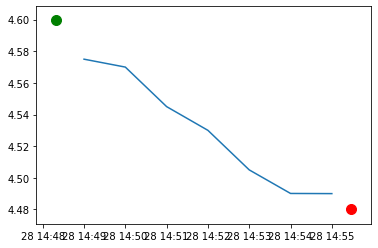

buy time:2020-02-28T14:48:18.909229417Z sell time:2020-02-28T14:55:28.450518678Z
{'rsi': 62.7287416124227, 'macd1': [0.02259814453563802, 0.02722855213512787, 0.02736316148361606, 0.03240579659729015, 0.03871548739464448], 'macd2': [-0.0040620492708445255, -0.002248912482555987, -0.0012153165610113703, 0.0007899475260408906, 0.003180572425762307], 'sell_macd': [0.01519243009870408, 0.01807085001733455, 0.018006360992665726, 0.021140442778733615, 0.025084656601919164], 'macd_signal': [0.00948795433112977, 0.01303607389192939, 0.015901491410266724, 0.01920235244767141, 0.023104979437066023], 'sell_macd_signal': [0.006948508357272867, 0.009172976689285203, 0.010939653549961308, 0.01297981139571577, 0.01540078043695645]}
{'rsi': 48.40199019443425, 'macd': [0.024079254306213826, 0.02194101891515654, 0.0186912118712792, 0.015142125708890397, 0.012174758235484973], 'scalp': 0, 'bail_out': 0, 'movement': -0.026030368763557504, 'too_close': 1, 'macd_signal': [0.019847389359533223, 0.02026611527

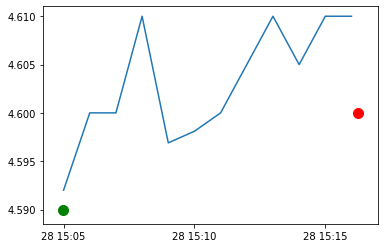

buy time:2020-02-28T15:04:58.143980214Z sell time:2020-02-28T15:16:14.003620677Z
{'rsi': 60.322318497695825, 'macd1': [0.01800448430835999, 0.020972112767269735, 0.02146273776764307, 0.0239957033631768, 0.02570676525867288], 'macd2': [0.009512053419010513, 0.01057712320357762, 0.011220232792331863, 0.012273777067643543, 0.01322344130963593], 'sell_macd': [0.010334036446575823, 0.012246614228359043, 0.012538926600808686, 0.014162300831278785, 0.015243341779290986], 'macd_signal': [0.021597118521315163, 0.021472117370506076, 0.021470241449933473, 0.02197533383258214, 0.02272162011780029], 'sell_macd_signal': [0.012951306039351282, 0.012810367677152833, 0.012756079461884003, 0.01303732373576296, 0.013478527344468565]}
{'rsi': 61.770039610879635, 'macd': [0.01633087396565358, 0.01623819389990544, 0.01569534977205045, 0.015328258896163405, 0.014843145760456977], 'scalp': 0, 'bail_out': 1, 'movement': 0.004357298474945635, 'too_close': 1, 'macd_signal': [0.016175835497229462, 0.0161883071777

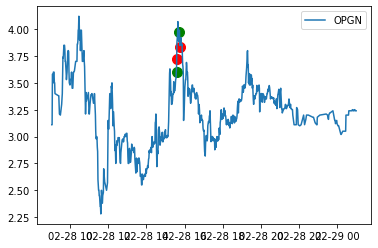

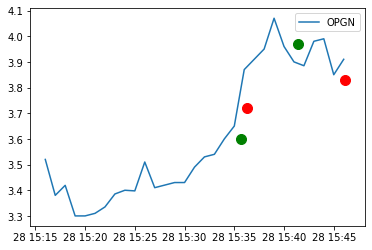

Delta = -0.020000000000000018


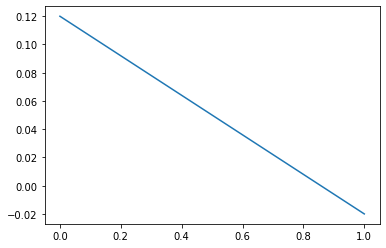

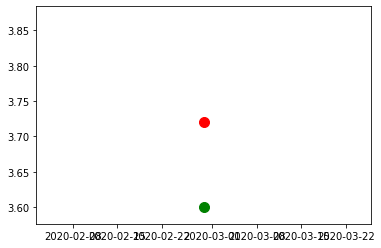

buy time:2020-02-28T15:35:41.650596328Z sell time:2020-02-28T15:36:19.681807157Z
{'rsi': 69.5810400018859, 'macd1': [0.08294440090179256, 0.08587857578365021, 0.08800445552546288, 0.09345345583001174, 0.09744736255488595], 'macd2': [0.15038837540395678, 0.15024151975989852, 0.15002765294021936, 0.15055055651325322, 0.15094919661541129], 'sell_macd': [0.04527266195041424, 0.04731784017453178, 0.04882164346378515, 0.052476274033803616, 0.055156813776235936], 'macd_signal': [0.09308592107579187, 0.09164445201736354, 0.09091645271898341, 0.09142385334118908, 0.09262855518392846], 'sell_macd_signal': [0.051519973984826925, 0.05067954722276789, 0.05030796647097134, 0.0507416279835378, 0.051624665142077426]}
{'rsi': 75.69964874225542, 'macd': [0.04731784017453178, 0.04882164346378515, 0.052476274033803616, 0.05723993065935318, 0.06540330035901043], 'scalp': 1, 'bail_out': 0, 'movement': 0.038809939333499514, 'too_close': 0, 'macd_signal': [0.05067954722276789, 0.05030796647097134, 0.050741627

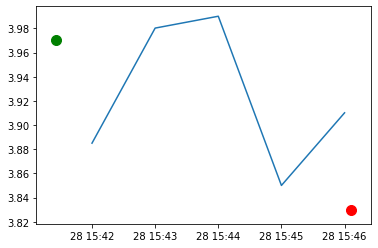

buy time:2020-02-28T15:41:25.611651213Z sell time:2020-02-28T15:46:06.325164735Z
{'rsi': 73.9422655705829, 'macd1': [0.14174367927941622, 0.15825167578629218, 0.17895450295508386, 0.18436037036134412, 0.18729248447893987], 'macd2': [0.16010849028518415, 0.16443448868904342, 0.17007078791836117, 0.17322506275841976, 0.17600998325259853], 'sell_macd': [0.08400318463709633, 0.09462609240361708, 0.1079085388138461, 0.11114280174631208, 0.11273907413854145], 'macd_signal': [0.10766998112184908, 0.1177863200547377, 0.13001995663480692, 0.14088803938011435, 0.15016892839987944], 'sell_macd_signal': [0.06156899223423208, 0.06818041226810909, 0.07612603757725649, 0.08312939041106761, 0.08905132715656237]}
{'rsi': 61.57041967733618, 'macd': [0.10531688991581056, 0.10594460257687777, 0.10556691630528237, 0.0966288891286462, 0.08996771354777833], 'scalp': 0, 'bail_out': 0, 'movement': -0.02267002518891695, 'too_close': 1, 'macd_signal': [0.0917226215265938, 0.09456701773665059, 0.09676699745037695

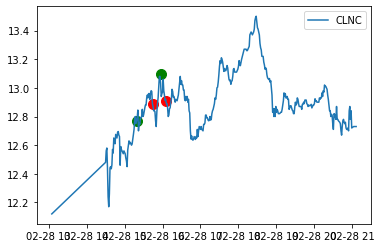

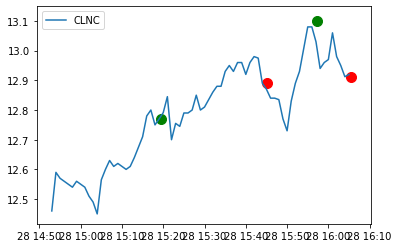

Delta = -0.06999999999999851


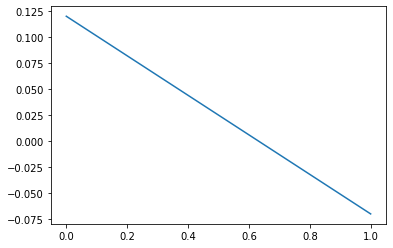

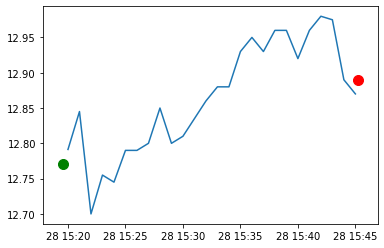

buy time:2020-02-28T15:19:33.401069214Z sell time:2020-02-28T15:45:11.845402108Z
{'rsi': 65.18679964421018, 'macd1': [0.03729844198700327, 0.047031910362868246, 0.055717312533554164, 0.05789855568684388, 0.06054313587034166], 'macd2': [0.03048005658123465, 0.03306374114635169, 0.035707804808785326, 0.03728363818264491, 0.03899369737517766], 'sell_macd': [0.021865647966720303, 0.02819215641152617, 0.033794732389146986, 0.035124080782239275, 0.036742740818645814], 'macd_signal': [0.027738295425348603, 0.031597018412852534, 0.03642107723699286, 0.04071657292696306, 0.04468188551563878], 'sell_macd_signal': [0.015448440367781605, 0.017997183576530518, 0.02115669333905381, 0.0239501708276909, 0.026508684825881885]}
{'rsi': 55.86071635666786, 'macd': [0.041810496319383716, 0.042140254101333596, 0.04159019193010849, 0.03620585527811215, 0.03231928314307453], 'scalp': 0, 'bail_out': 1, 'movement': 0.010571652310101785, 'too_close': 1, 'macd_signal': [0.04069975664322902, 0.04098785613484994, 0

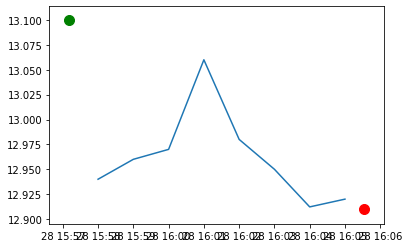

buy time:2020-02-28T15:57:09.893082987Z sell time:2020-02-28T16:05:32.873244753Z
{'rsi': 69.49364036290447, 'macd1': [0.007517311868813437, 0.013344123988204615, 0.023740126372475245, 0.03759750571773246, 0.04962140684899907], 'macd2': [0.052105184692377904, 0.05234525890372055, 0.053681936122705665, 0.056025385357569846, 0.05841170089055403], 'sell_macd': [0.0008834872127323479, 0.004885086348220824, 0.01183587676096387, 0.02099446829347862, 0.028897338730587308], 'macd_signal': [0.02555951633515568, 0.023116437865765466, 0.023241175567107423, 0.02611244159723243, 0.03081423464758576], 'sell_macd_signal': [0.012207840153374814, 0.010743289392344016, 0.010961806866067987, 0.012968339151550113, 0.01615413906735755]}
{'rsi': 48.62630210072027, 'macd': [0.027425047216647513, 0.025572925194508045, 0.022239155759145035, 0.017388956773677577, 0.013269464619110494], 'scalp': 0, 'bail_out': 0, 'movement': -0.014503816793893093, 'too_close': 1, 'macd_signal': [0.023028593728484696, 0.0235374600

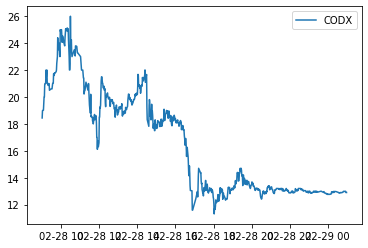

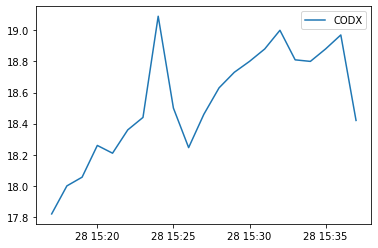

Delta = 0


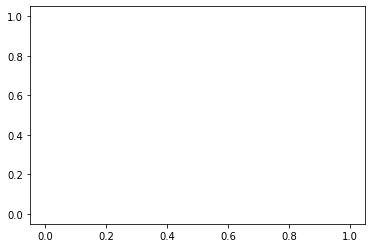

TPC analysis for run 74
buy-price 13.31 sell-price 13.5


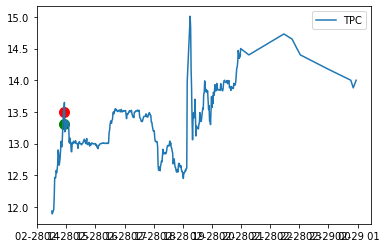

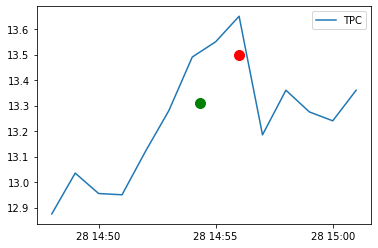

Delta = 0.1899999999999995


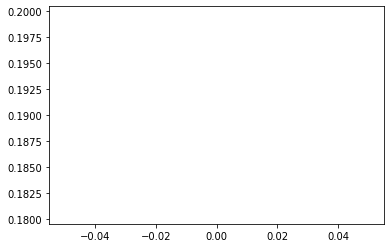

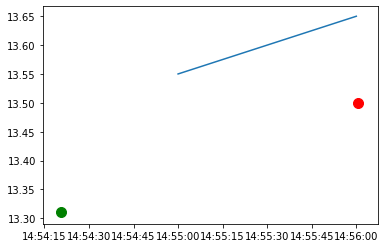

buy time:2020-02-28T14:54:20.581627414Z sell time:2020-02-28T14:56:00.402014256Z
{'rsi': 74.3059542074616, 'macd1': [0.16003650671817482, 0.16419881619424004, 0.17914992685276232, 0.2015856981453048, 0.21965833151529957], 'macd2': [0.027819475931892157, 0.03353129459078019, 0.041451634277201777, 0.051231280451272454, 0.06070670657071631], 'sell_macd': [0.10383654002493437, 0.10573726486793866, 0.11467630676030716, 0.12846417957565492, 0.1393577924242937], 'macd_signal': [0.10752086929189722, 0.11885645867236579, 0.13091515230844508, 0.14504926147581704, 0.15997107548371353], 'sell_macd_signal': [0.07209162535947836, 0.07882075326117041, 0.08599186396099776, 0.09448632708392919, 0.1034606201520021]}
{'rsi': 78.32890314275072, 'macd': [0.10573726486793866, 0.11467630676030716, 0.12846417957565492, 0.1484487015152034, 0.16521003417569347], 'scalp': 0, 'bail_out': 0, 'movement': 0.01764926774314692, 'too_close': 0, 'macd_signal': [0.07882075326117041, 0.08599186396099776, 0.094486327083929

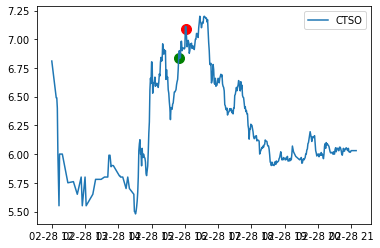

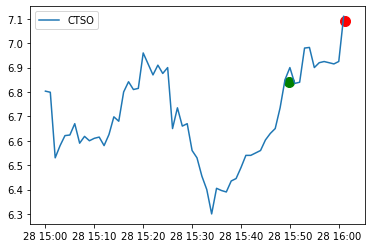

Delta = 0.25


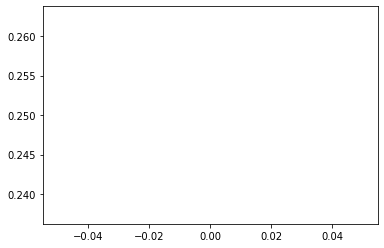

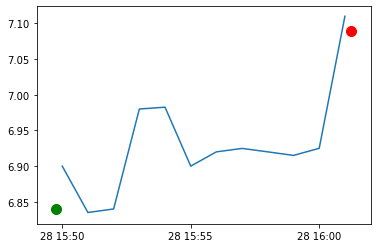

buy time:2020-02-28T15:49:46.456018288Z sell time:2020-02-28T16:01:15.015111861Z
{'rsi': 69.02138045512727, 'macd1': [-0.017144169614600635, -0.007866090523791058, 0.0010881434137237633, 0.014871795149227651, 0.03387754172092716], 'macd2': [0.09323064716259033, 0.09199301385953174, 0.09102709371328022, 0.09135228738326173, 0.09318469901264681], 'sell_macd': [-0.013698722646652506, -0.007289579056784845, -0.0011618102977086764, 0.008043747310632732, 0.020566990287123943], 'macd_signal': [-0.029794552876808933, -0.02540886040620536, -0.020109459642219534, -0.013113208683930096, -0.0037150586029586433], 'sell_macd_signal': [-0.02430077599507984, -0.02089853660742084, -0.016951191345478407, -0.011952203614256179, -0.005448364833980153]}
{'rsi': 72.5069936095477, 'macd': [0.06255034104581725, 0.061479078183959146, 0.059586158055446425, 0.057856789668872644, 0.06329031054077738], 'scalp': 1, 'bail_out': 0, 'movement': 0.03362573099415211, 'too_close': 0, 'macd_signal': [0.046584625142961925,

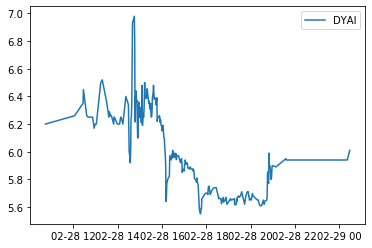

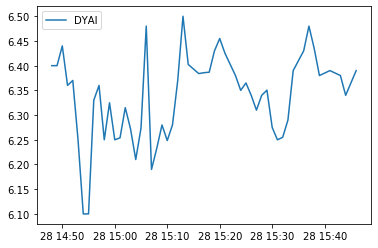

Delta = 0


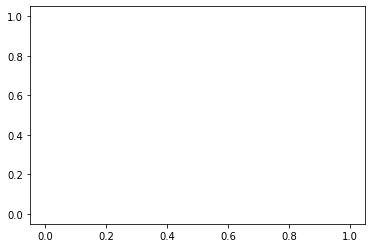

DUST analysis for run 74
buy-price 7.54 sell-price 7.35


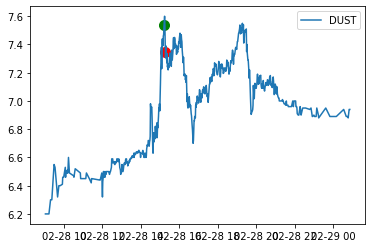

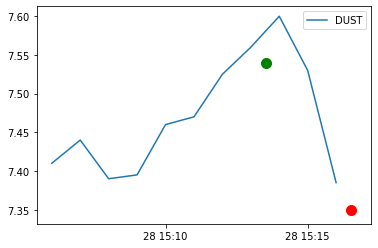

Delta = -0.1900000000000004


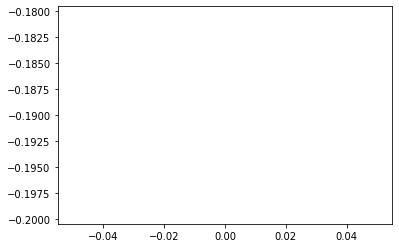

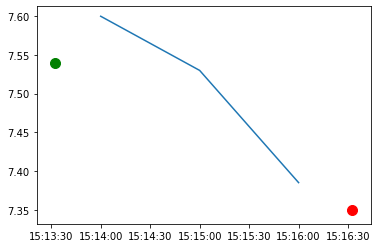

buy time:2020-02-28T15:13:32.318129026Z sell time:2020-02-28T15:16:32.444530802Z
{'rsi': 73.7721946241373, 'macd1': [0.19886514817948342, 0.20090307106384486, 0.20100796140271715, 0.20318691581177362, 0.20377513461303742], 'macd2': [0.19422657383952835, 0.1970837558544849, 0.1995571828009055, 0.20239329902342007, 0.20491882090743108], 'sell_macd': [0.11652092588977236, 0.11768245532619037, 0.11757868014253958, 0.11882796337420753, 0.11903743130311462], 'macd_signal': [0.18095098376298702, 0.18494140122315858, 0.1881547132590703, 0.19116115376961096, 0.19368394993829624], 'sell_macd_signal': [0.10508814147638709, 0.10760700424634775, 0.10960133942558611, 0.1114466642153104, 0.11296481763287124]}
{'rsi': 55.20450319850539, 'macd': [0.11882796337420753, 0.12007639234207623, 0.1215676825463623, 0.11751456215299605, 0.10295999350682816], 'scalp': 0, 'bail_out': 0, 'movement': -0.026525198938992064, 'too_close': 1, 'macd_signal': [0.1114466642153104, 0.11317260984066356, 0.11485162438180331,

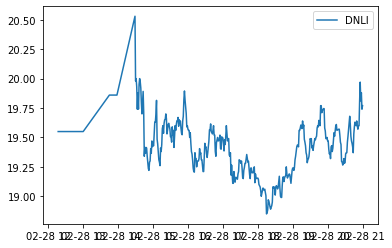

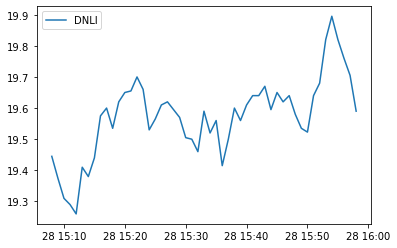

Delta = 0


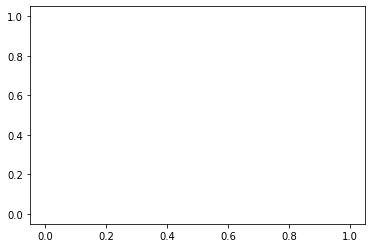

TNK analysis for run 74


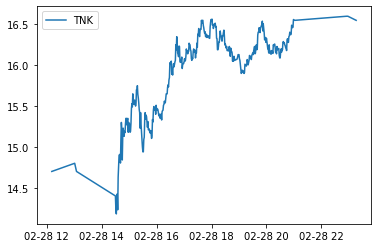

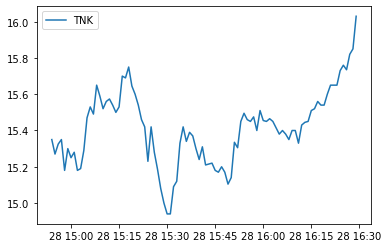

Delta = 0


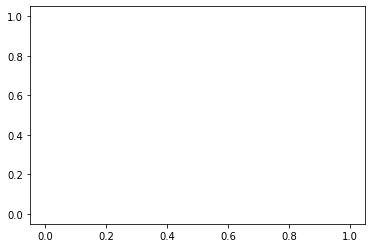

SCOR analysis for run 74


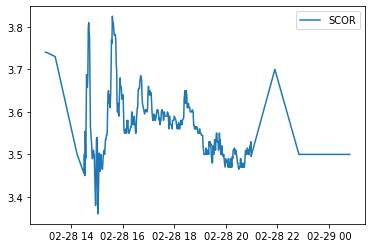

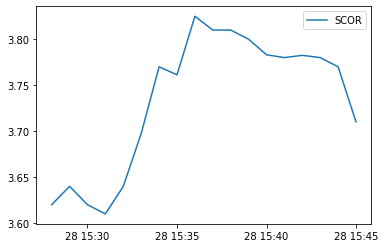

Delta = 0


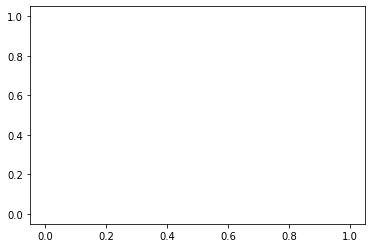

JDST analysis for run 74


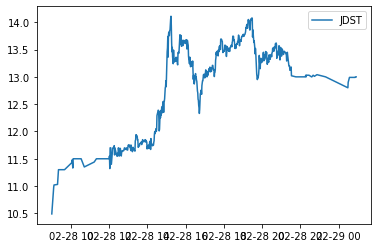

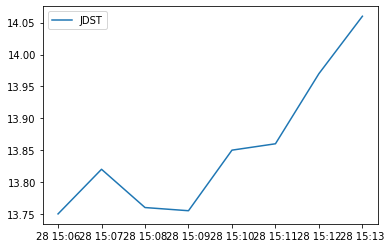

Delta = 0


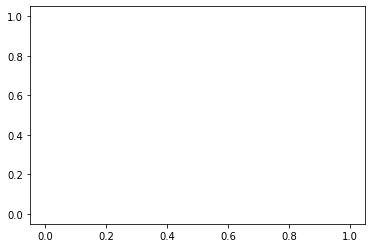

NNVC analysis for run 74


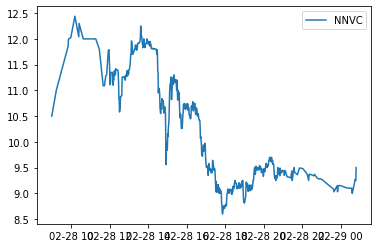

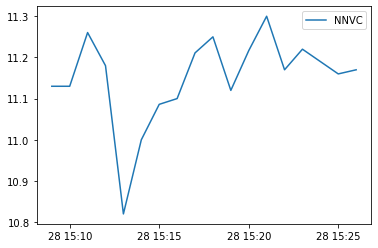

Delta = 0


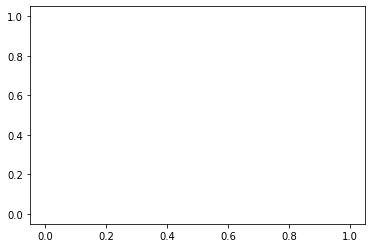

XAIR analysis for run 74


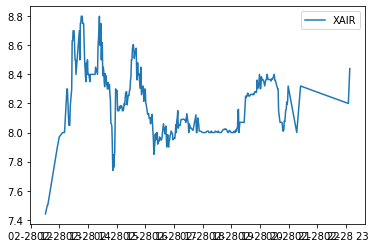

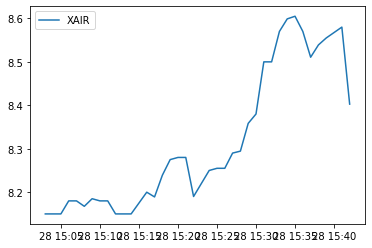

Delta = 0


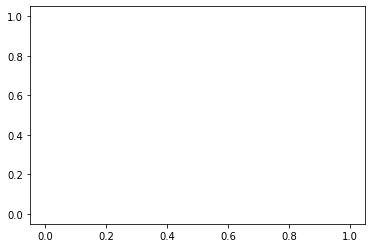

NTLA analysis for run 74
buy-price 12.36 sell-price 12.17


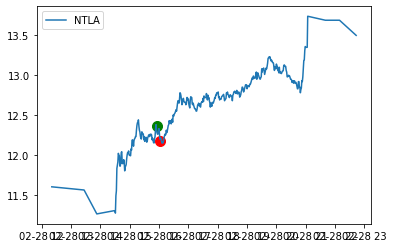

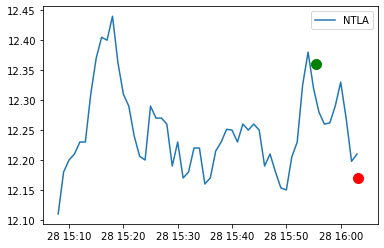

Delta = -0.1899999999999995


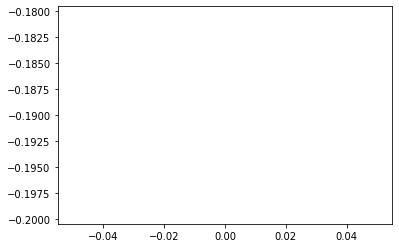

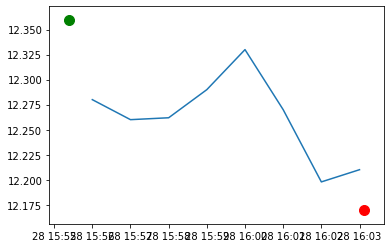

buy time:2020-02-28T15:55:23.248278304Z sell time:2020-02-28T16:03:07.144997541Z
{'rsi': 65.96730603885601, 'macd1': [-0.00814017851219262, -0.005290432429903902, 0.004612820853139965, 0.016674767774578214, 0.02553612484665102], 'macd2': [0.03212425537497765, 0.03161940974600164, 0.03263015447560669, 0.03438113528524944, 0.035857137804981676], 'sell_macd': [-0.00689333675448367, -0.00488213966351303, 0.0017042754679366112, 0.009650777187665938, 0.015457781421380545], 'macd_signal': [0.00025431362036317613, -0.0008546355896902396, 0.00023885569887580125, 0.003526038114016284, 0.007928055460543232], 'sell_macd_signal': [-0.0020495922924043527, -0.002616101766626088, -0.0017520263197135482, 0.0005285343817623487, 0.0035143837896859887]}
{'rsi': 46.07749712881475, 'macd': [0.011124739110149662, 0.013509870283272107, 0.01207607807683253, 0.007051355863024966, 0.0036781780878101245], 'scalp': 0, 'bail_out': 0, 'movement': -0.013333333333333265, 'too_close': 1, 'macd_signal': [0.0078855798559

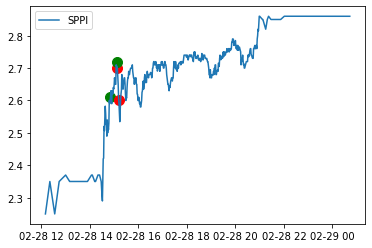

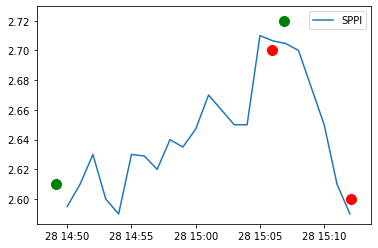

Delta = -0.029999999999999805


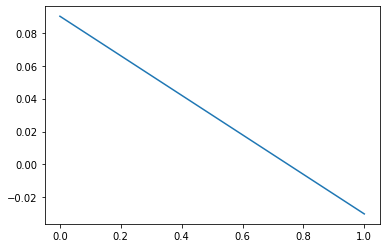

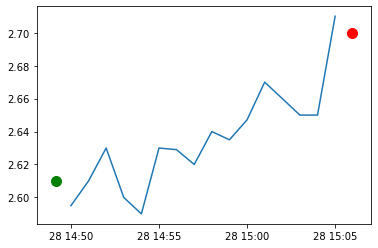

buy time:2020-02-28T14:49:09.620042877Z sell time:2020-02-28T15:05:55.754639891Z
{'rsi': 67.27199305160444, 'macd1': [0.017947876167909715, 0.017043615501627585, 0.01773636152660174, 0.023661033067233106, 0.029612715521377453], 'macd2': [-0.0033881176745480523, -0.0028703429343148734, -0.0020695108475439206, -0.00020985763880787545, 0.0018180917669727847], 'sell_macd': [0.012199471642828197, 0.011481232958498566, 0.01181142056865081, 0.015551678179566153, 0.01929276621171372], 'macd_signal': [0.01114845970190071, 0.012327490861846086, 0.013409264994797217, 0.015459618609284395, 0.018290237991703005], 'sell_macd_signal': [0.008152738924082286, 0.008818437730965542, 0.009417034298502595, 0.010643963074715306, 0.012373723702114989]}
{'rsi': 69.75011734281897, 'macd': [0.024910668884684295, 0.024826569541652965, 0.02391913408550339, 0.02290140341726321, 0.024408348306721894], 'scalp': 1, 'bail_out': 0, 'movement': 0.03061302389495383, 'too_close': 0, 'macd_signal': [0.02306591414569131, 0.

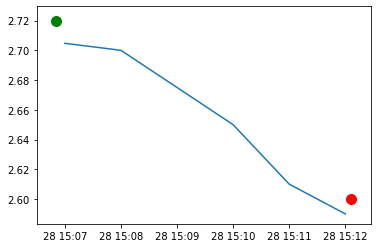

buy time:2020-02-28T15:06:50.985047135Z sell time:2020-02-28T15:12:06.390474314Z
{'rsi': 72.69721358649778, 'macd1': [0.04091580927301797, 0.03968958605618411, 0.038276566885659946, 0.04151962517786245, 0.045182766287960696], 'macd2': [0.01810511682419058, 0.01892372558494415, 0.01964660597524981, 0.02123987321003229, 0.022991631872325335], 'sell_macd': [0.024826569541652965, 0.02391913408550339, 0.02290140341726321, 0.02492782882620226, 0.027222084614646036], 'macd_signal': [0.0379614073976673, 0.03830704312937066, 0.038300947880628516, 0.0389446833400753, 0.040192299929652384], 'sell_macd_signal': [0.02341804522488364, 0.023518262997007593, 0.023394891081058716, 0.023701478630087425, 0.024405599826999146]}
{'rsi': 47.920935616743414, 'macd': [0.026135306193875163, 0.02428579157069244, 0.021230510155606286, 0.016496128401569887, 0.012592764328274608], 'scalp': 0, 'bail_out': 0, 'movement': -0.043956043956043994, 'too_close': 1, 'macd_signal': [0.02491544056492469, 0.02478951076607824,

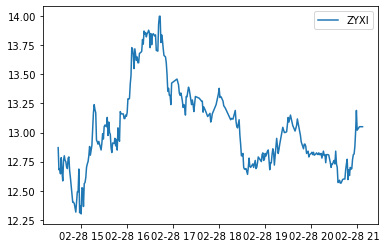

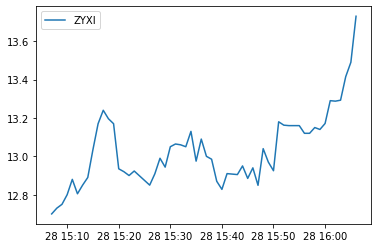

Delta = 0


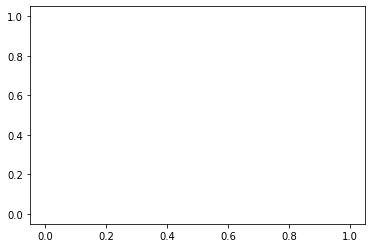

MIK analysis for run 74
buy-price 4.27 sell-price 4.18
buy-price 4.22 sell-price 4.15


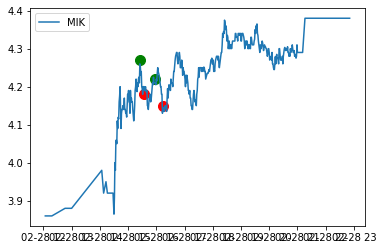

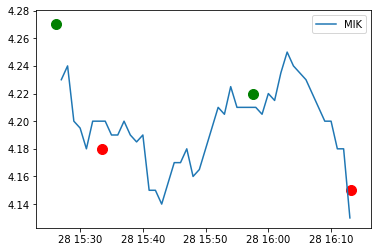

Delta = -0.15999999999999925


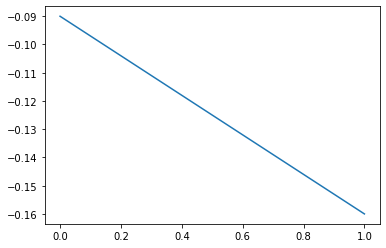

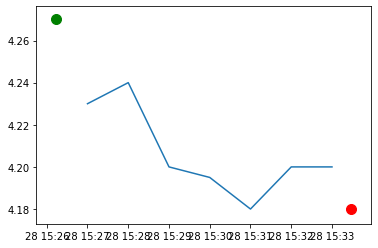

buy time:2020-02-28T15:26:13.15294945Z sell time:2020-02-28T15:33:28.625582698Z
{'rsi': 66.55978296490338, 'macd1': [0.0195041610039981, 0.020995645321490564, 0.020728339355748027, 0.024271295201895526, 0.0275682401502797], 'macd2': [0.021975497559302504, 0.02243486242684334, 0.022581707333082512, 0.023480373186711034, 0.024429556967779043], 'sell_macd': [0.011388328333915787, 0.012354561279671827, 0.012167800441563514, 0.0144616517308096, 0.01658073518047143], 'macd_signal': [0.01553778203558425, 0.016629354692765514, 0.017449151625362015, 0.01881358034066872, 0.020564512302590914], 'sell_macd_signal': [0.008704129963595436, 0.009434216226810715, 0.009980933069761274, 0.010877076801970939, 0.012017808477671036]}
{'rsi': 47.69879286396254, 'macd': [0.012997190537204162, 0.010771493986263536, 0.008118074674021258, 0.006984006707675405, 0.004970654958475151], 'scalp': 0, 'bail_out': 0, 'movement': -0.021077283372365307, 'too_close': 1, 'macd_signal': [0.013085062385243946, 0.012622348705

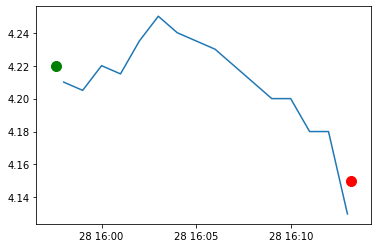

buy time:2020-02-28T15:57:36.479119183Z sell time:2020-02-28T16:13:11.883468447Z
{'rsi': 59.18661525901708, 'macd1': [0.0014752410480491918, 0.004601933650736356, 0.005802596702405793, 0.006677160669355864, 0.00808398815720146], 'macd2': [0.011749100865624307, 0.012102291562095857, 0.012167978337918939, 0.012208951291864167, 0.012387057234231058], 'sell_macd': [0.0007548262758971802, 0.0028139246961291775, 0.0036026517158411764, 0.0041704565141129635, 0.005078220558037749], 'macd_signal': [-0.0028932640819954044, -0.0013942245354490522, 4.513971212191702e-05, 0.0013715439035687066, 0.0027140327542952572], 'sell_macd_signal': [-0.0023402920129500034, -0.0013094486711341673, -0.0003270285937390985, 0.000572468427831314, 0.001473618853872601]}
{'rsi': 34.38785337432048, 'macd': [0.004623509755838917, 0.0033080448372810878, 0.0012010845781800228, -0.00045630113771899516, -0.0027808055768909767], 'scalp': 0, 'bail_out': 0, 'movement': -0.014218009478672893, 'too_close': 1, 'macd_signal': [0

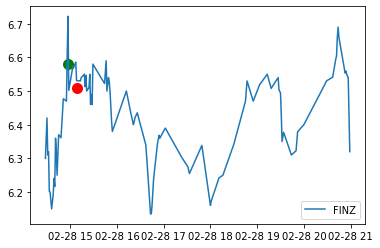

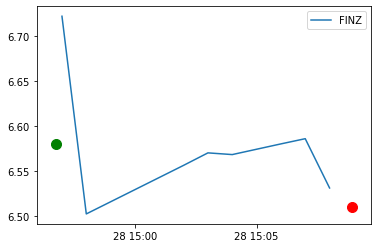

Delta = -0.07000000000000028


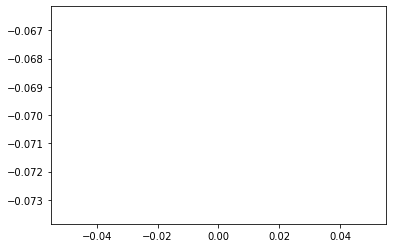

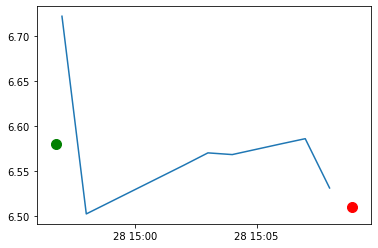

buy time:2020-02-28T14:56:45.754905525Z sell time:2020-02-28T15:08:54.334472847Z
{'rsi': 74.46093209499325, 'macd1': [0.182153021345429, 0.18056812398930333, 0.18651422293832898, 0.18848892470251322, 0.19905612494849834], 'macd2': [0.12461784282677435, 0.1278272245776435, 0.13242917520156894, 0.13633935980166711, 0.14195790331451086], 'sell_macd': [0.10962877567498364, 0.10817478990847729, 0.11165772580589461, 0.11255796513107796, 0.11907038583731211], 'macd_signal': [0.17427300618855593, 0.1755320297487054, 0.17772846838663012, 0.17988055964980673, 0.18371567270954506], 'sell_macd_signal': [0.1064374633502356, 0.10678492866188394, 0.10775948809068607, 0.10871918349876444, 0.11078942396647398]}
{'rsi': 61.43598530484981, 'macd': [0.11588820277276302, 0.11162778168407073, 0.1074764434112705, 0.1031471351024491, 0.09558212687346579], 'scalp': 0, 'bail_out': 0, 'movement': -0.011966717095310195, 'too_close': 1, 'macd_signal': [0.11648980792304751, 0.11551740267525215, 0.11390921082245582,

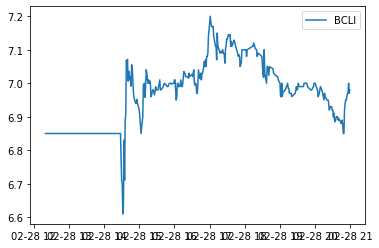

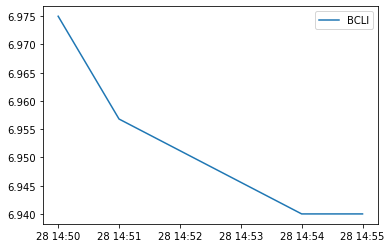

Delta = 0


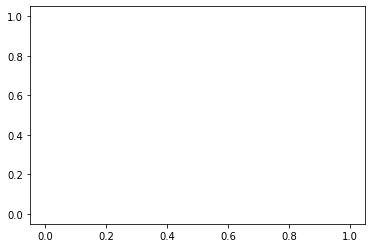

WTID not in high_15m, skipping...
PBI analysis for run 74
buy-price 3.48 sell-price 3.44


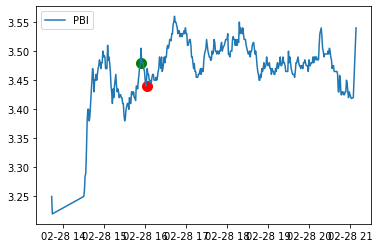

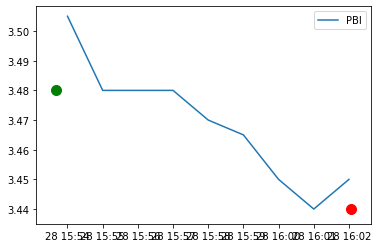

Delta = -0.040000000000000036


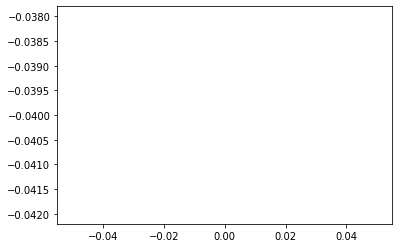

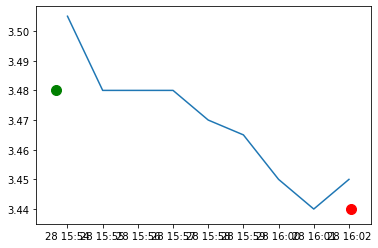

buy time:2020-02-28T15:53:40.677860256Z sell time:2020-02-28T16:02:03.527096323Z
{'rsi': 69.6005637318945, 'macd1': [0.0025798631628171087, 0.004291172020772116, 0.006380759621496868, 0.009141766891335834, 0.011599629944441858], 'macd2': [0.003310436689681673, 0.0036205544239131804, 0.004060018113945851, 0.004697749372766236, 0.005356937149277208], 'sell_macd': [0.002039968017863991, 0.0031227632063206556, 0.004445424869971681, 0.006197558310868434, 0.007742109585452184], 'macd_signal': [-0.0010251070095788988, 3.8148796491304336e-05, 0.0013066709614924172, 0.0028736901474611005, 0.004618878106857252], 'sell_macd_signal': [-0.0002801360060958269, 0.0004004438363874696, 0.0012094400431043118, 0.002207063696657136, 0.0033140728744161458]}
{'rsi': 46.401200375478176, 'macd': [0.010167629117823651, 0.009274100918307049, 0.0076781815301343315, 0.0058154108181796005, 0.004319545187849272], 'scalp': 0, 'bail_out': 0, 'movement': -0.011321839080459799, 'too_close': 1, 'macd_signal': [0.0081454

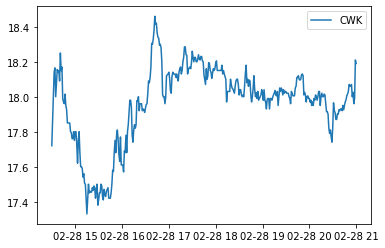

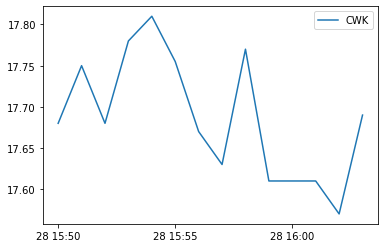

Delta = 0


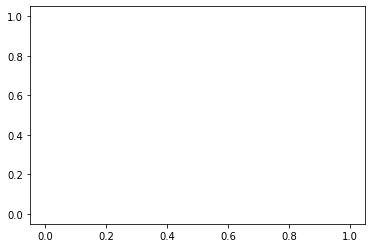

ALT analysis for run 74


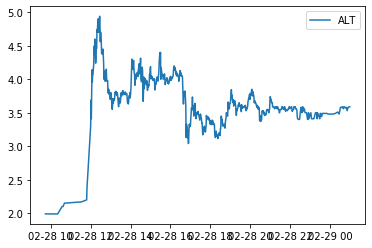

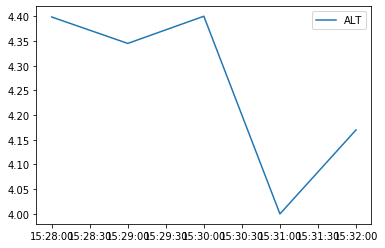

Delta = 0


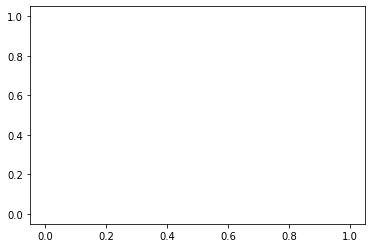

ICAD not in high_15m, skipping...
DPK not in high_15m, skipping...
SPXS analysis for run 74
buy-price 18.04 sell-price 18.13


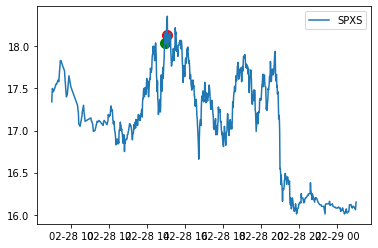

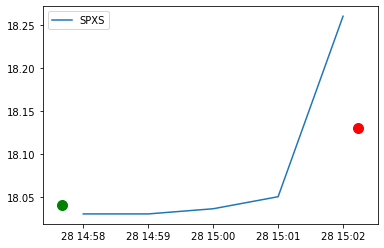

Delta = 0.08999999999999986


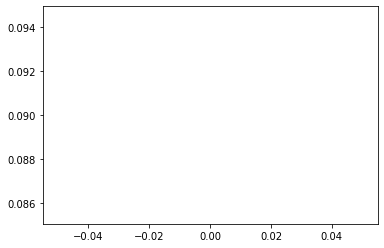

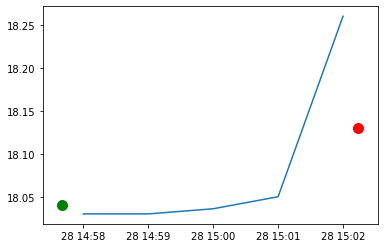

buy time:2020-02-28T14:57:40.61337284Z sell time:2020-02-28T15:02:13.573028401Z
{'rsi': 66.32854106430732, 'macd1': [0.28534993846199797, 0.2864543720699473, 0.296818764531217, 0.3023541858096337, 0.3053992687393361], 'macd2': [0.2851759582811475, 0.28903425836053387, 0.29468072435382453, 0.29956428906919896, 0.30401004086999706], 'sell_macd': [0.1626930637255164, 0.1633684057416218, 0.1700846669783047, 0.17362870603314562, 0.17553797404947602], 'macd_signal': [0.30035892974917305, 0.2975780182133279, 0.29742616747690576, 0.29841177114345135, 0.2998092706626283], 'sell_macd_signal': [0.17353844598590193, 0.1715044379370459, 0.17122048374529766, 0.17170212820286726, 0.17246929737218902]}
{'rsi': 65.5906869858796, 'macd': [0.1783607762477608, 0.17366986148726227, 0.16807083879742635, 0.16225249853524915, 0.15924791523309523], 'scalp': 0, 'bail_out': 1, 'movement': 0.004044993627749786, 'too_close': 1, 'macd_signal': [0.17458681392652395, 0.1744034234386716, 0.17313690651042254, 0.1709600

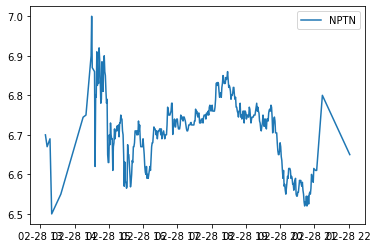

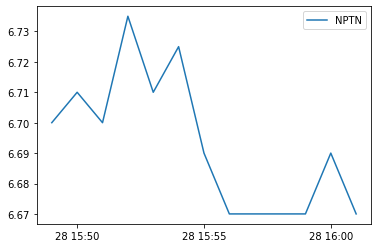

Delta = 0


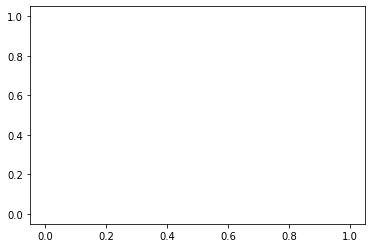

PVAC analysis for run 74


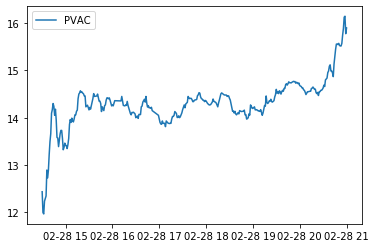

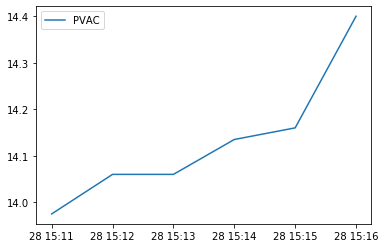

Delta = 0


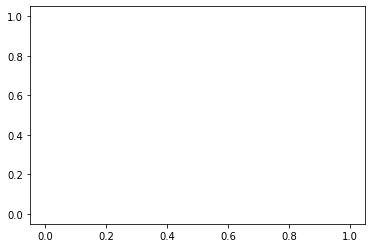

GLYC analysis for run 74


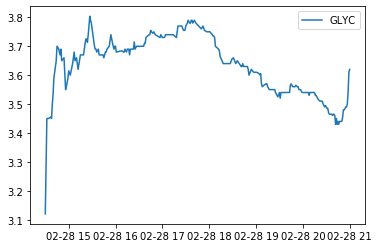

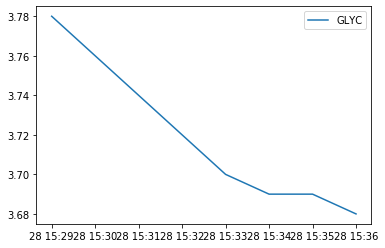

Delta = 0


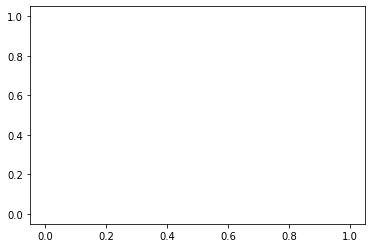

FTCH analysis for run 74


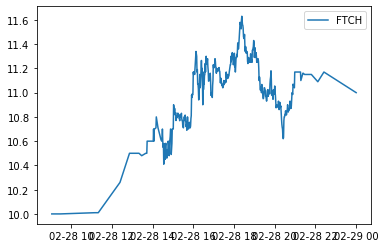

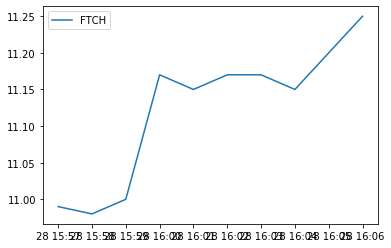

Delta = 0


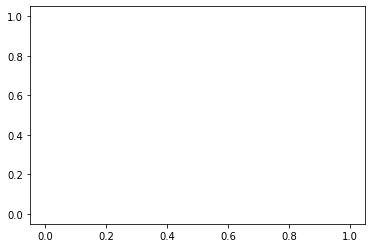

BCRX analysis for run 74


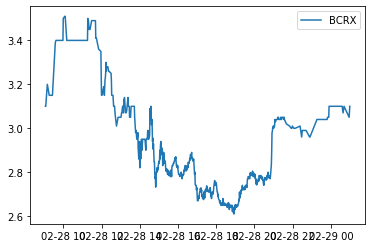

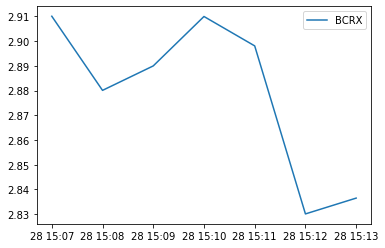

Delta = 0


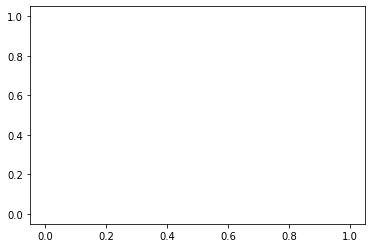

KRMD analysis for run 74


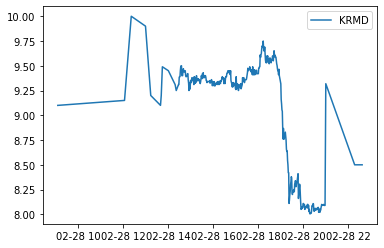

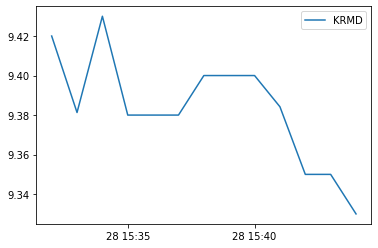

Delta = 0


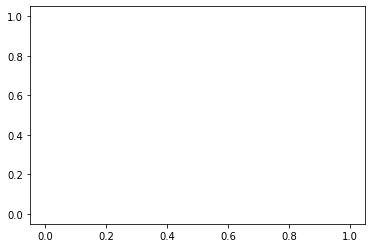

DWT analysis for run 74
buy-price 8.48 sell-price 8.51


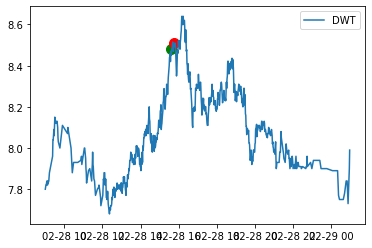

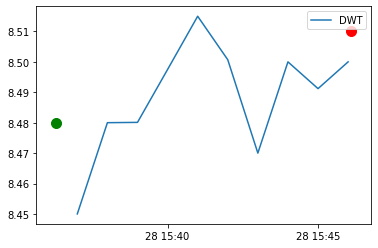

Delta = 0.02999999999999936


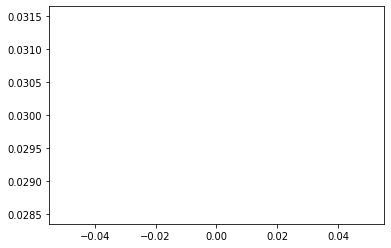

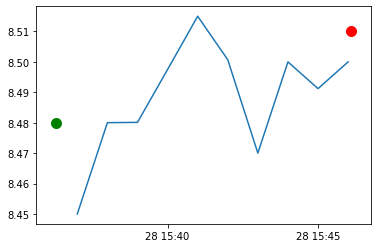

buy time:2020-02-28T15:36:17.746080625Z sell time:2020-02-28T15:46:06.055503111Z
{'rsi': 72.40074930379572, 'macd1': [0.07304576785456973, 0.07618242483039062, 0.07458086063959257, 0.07646475353124949, 0.07786706558561107], 'macd2': [0.10525287725287313, 0.10583770848561791, 0.10556675519997505, 0.10594831036548236, 0.1062898398314438], 'sell_macd': [0.04228428569163967, 0.04431889321348237, 0.04325080955240601, 0.044454240341796236, 0.04533413134207542], 'macd_signal': [0.06351751612647898, 0.0660504978672613, 0.06775657042172756, 0.06949820704363194, 0.07117197875202777], 'sell_macd_signal': [0.035798252005490125, 0.037502380247088574, 0.03865206610815206, 0.0398125009548809, 0.0409168270323198]}
{'rsi': 67.10100465542067, 'macd': [0.04176674735237107, 0.03884224350297849, 0.03761740617224518, 0.035717306873333854, 0.034749472265435344], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035377358490565284, 'too_close': 0, 'macd_signal': [0.04191665970810123, 0.04130177646707668, 0.0405649024

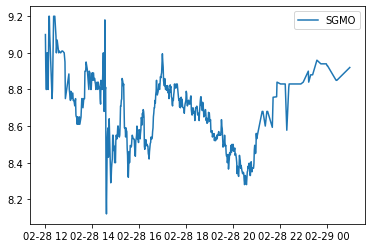

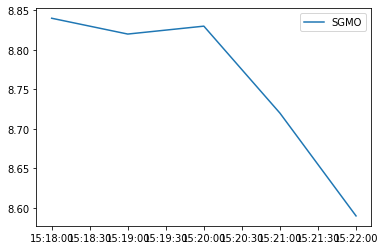

Delta = 0


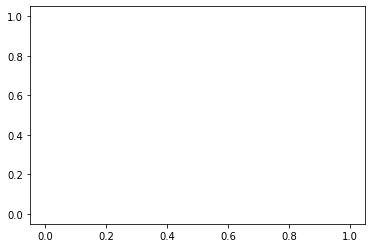

OSMT analysis for run 74
buy-price 5.58 sell-price 5.45


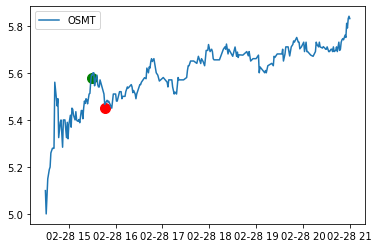

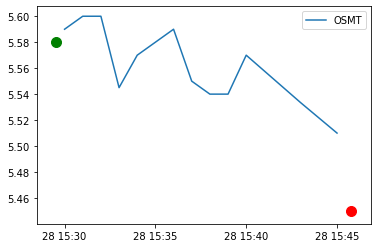

Delta = -0.1299999999999999


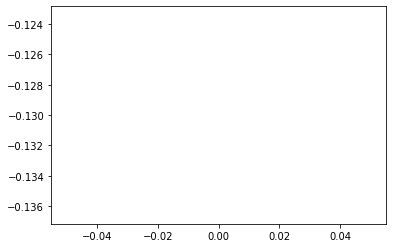

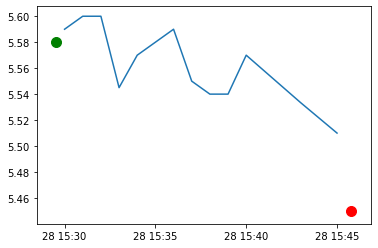

buy time:2020-02-28T15:29:32.576162446Z sell time:2020-02-28T15:45:47.705668703Z
{'rsi': 67.85459785635432, 'macd1': [0.029038537185563484, 0.03108835024885792, 0.03254745335828968, 0.03710091074193844, 0.04184107352693989], 'macd2': [0.017009992112454242, 0.01809125335428341, 0.019098697218351113, 0.02075312886263081, 0.022561939217704108], 'sell_macd': [0.017238205827063702, 0.018533636268231568, 0.019437430946178225, 0.022351590033587776, 0.025371043997367337], 'macd_signal': [0.02521637329482343, 0.02639076868563033, 0.0276221056201622, 0.02951786664451745, 0.031982508021001936], 'sell_macd_signal': [0.014854792854882013, 0.015590561537551924, 0.016359935419277185, 0.017558266342139302, 0.01912082187318491]}
{'rsi': 49.15711790579324, 'macd': [0.023029103426616793, 0.020564850636578313, 0.019936019233476543, 0.017285812695559066, 0.013780641202434829], 'scalp': 0, 'bail_out': 0, 'movement': -0.012544802867383563, 'too_close': 1, 'macd_signal': [0.02571739117466113, 0.02468688306704

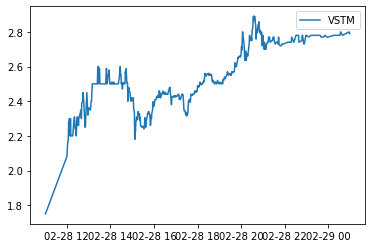

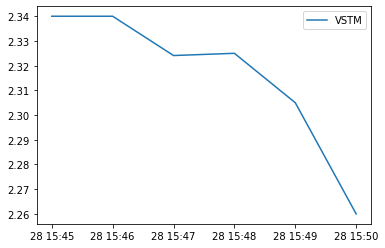

Delta = 0


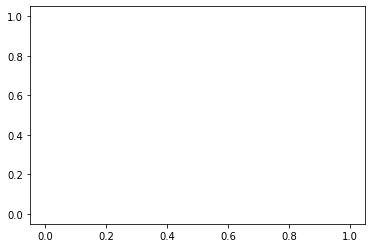

DSLV analysis for run 74


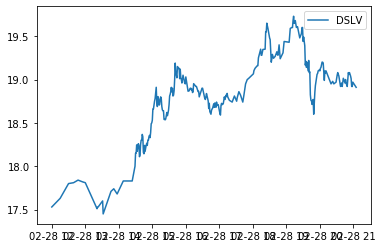

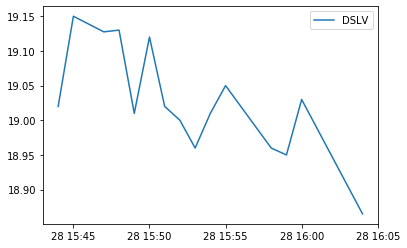

Delta = 0


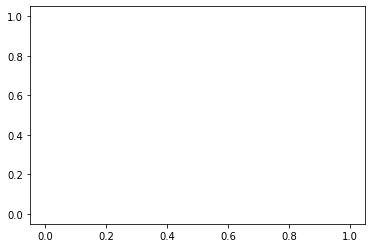

In [32]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
        if symbol not in high_15m:
            print(f'{symbol} not in high_15m, skipping...')
            continue
            
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
            
            t = parser.isoparse(trade[0])
            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
                continue
                
                
            print(f'buy-price {trade[1]} sell-price {trade[3]}')

            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
            t = parser.isoparse(trade[0])
            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
                continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            if trade[1] < high_15m[symbol]:
                continue
            t = parser.isoparse(trade[0])
            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

